In [1]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import random
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
data_path = "preprocessed_dataset.csv"
df = pd.read_csv(data_path)

In [19]:
df['Big_city'] = df['city_pop'].apply(lambda x: True if x > 20000 else False)

transaction_data = (
    df.groupby(['line_number', 'Big_city'])['category']
    .apply(list)
    .reset_index()
)

def add_random_categories(transaction, transaction_data, max_categories=4):
    all_categories = transaction_data['category'].explode().unique()
    remaining_categories = list(set(all_categories) - set(transaction))
    
    num_categories_to_add = min(max_categories - len(transaction), len(remaining_categories))
    categories_to_add = random.sample(remaining_categories, num_categories_to_add)
    transaction.extend(categories_to_add)
    
    return transaction

transaction_data['category'] = transaction_data['category'].apply(
    lambda x: add_random_categories(x, transaction_data, max_categories=4)
)

one_hot = pd.get_dummies(transaction_data.explode('category'), columns=['category'], prefix='', prefix_sep='')
transaction_df = (
    one_hot.groupby('line_number')
    .max()
    .astype(int)
)

transaction_df.to_csv("transaction_data.csv", index=False)

for col in transaction_df.columns:
    if not set(transaction_df[col].unique()).issubset({0, 1}):
        print(f"Column {col} contains non-binary values: {transaction_df[col].unique()}")

In [21]:
frequent_itemsets = apriori(transaction_df, min_support=0.05, use_colnames=True, max_len=4,)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6, num_itemsets=len(df))

print(frequent_itemsets)
print(f"rules: {rules}")
print(rules.head())

def run_apriori_on_subset(transaction_data, city_value, city_column):
    subset_data = transaction_data[transaction_data[city_column] == city_value]
    print(f"Subset data shape: {subset_data.shape}")
    frequent_itemsets_subset = apriori(subset_data, min_support=0.005, use_colnames=True)
    rules_subset = association_rules(frequent_itemsets_subset, metric="confidence", min_threshold=0.1, num_itemsets=len(subset_data))

    return frequent_itemsets_subset, rules_subset

frequent_itemsets_big, rules_big = run_apriori_on_subset(transaction_df, True, 'Big_city')
frequent_itemsets_small, rules_small = run_apriori_on_subset(transaction_df, False, 'Big_city')

print("Big City Rules:")
print(rules_big)

print("Small City Rules:")
print(rules_small)

c:\Users\jarne\OneDrive - UC Leuven-Limburg\BAC 3\Semester 1\Data Mining\.venv\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
c:\Users\jarne\OneDrive - UC Leuven-Limburg\BAC 3\Semester 1\Data Mining\.venv\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
c:\Users\jarne\OneDrive - UC Leuven-Limburg\BAC 3\Semester 1\Data Mining\.venv\lib\site-packages\mlxtend\frequent_patterns\association_rules.py:182: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


      support                       itemsets
0    0.254403                     (Big_city)
1    0.282897                (entertainment)
2    0.286591                  (food_dining)
3    0.312644                (gas_transport)
4    0.253941                  (grocery_net)
..        ...                            ...
115  0.069982  (personal_care, shopping_pos)
116  0.058044        (travel, personal_care)
117  0.072357   (shopping_net, shopping_pos)
118  0.061078         (travel, shopping_net)
119  0.062595         (travel, shopping_pos)

[120 rows x 2 columns]
rules: Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: 

c:\Users\jarne\OneDrive - UC Leuven-Limburg\BAC 3\Semester 1\Data Mining\.venv\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


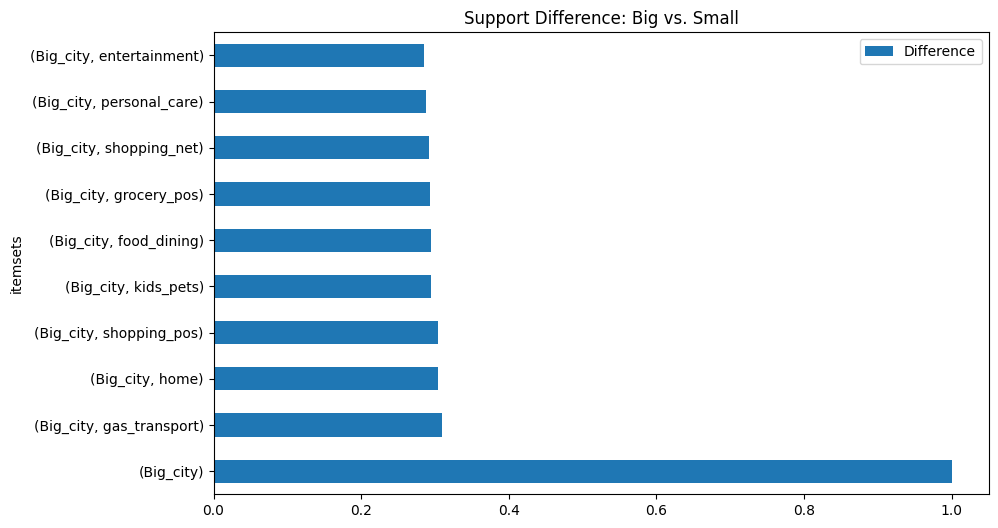

In [22]:
def plot_support_difference(frequent_itemsets_1, frequent_itemsets_2, label1, label2):
    merged = pd.merge(
        frequent_itemsets_1.rename(columns={'support': f'support_{label1}'}),
        frequent_itemsets_2.rename(columns={'support': f'support_{label2}'}),
        on='itemsets', how='outer'
    ).fillna(0)
    merged['Difference'] = merged[f'support_{label1}'] - merged[f'support_{label2}']
    merged = merged.sort_values('Difference', key=abs, ascending=False).head(10)
    merged.set_index('itemsets')[['Difference']].plot(kind='barh', figsize=(10, 6))
    plt.title(f'Support Difference: {label1} vs. {label2}')
    plt.show()

if frequent_itemsets_big is not None and frequent_itemsets_small is not None:
    plot_support_difference(frequent_itemsets_big, frequent_itemsets_small, 'Big', 'Small')

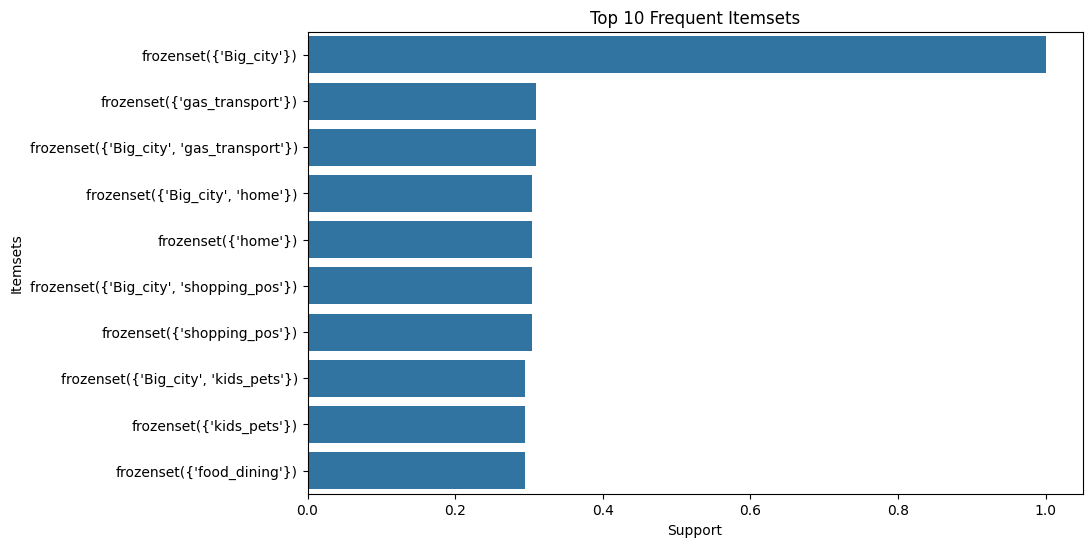

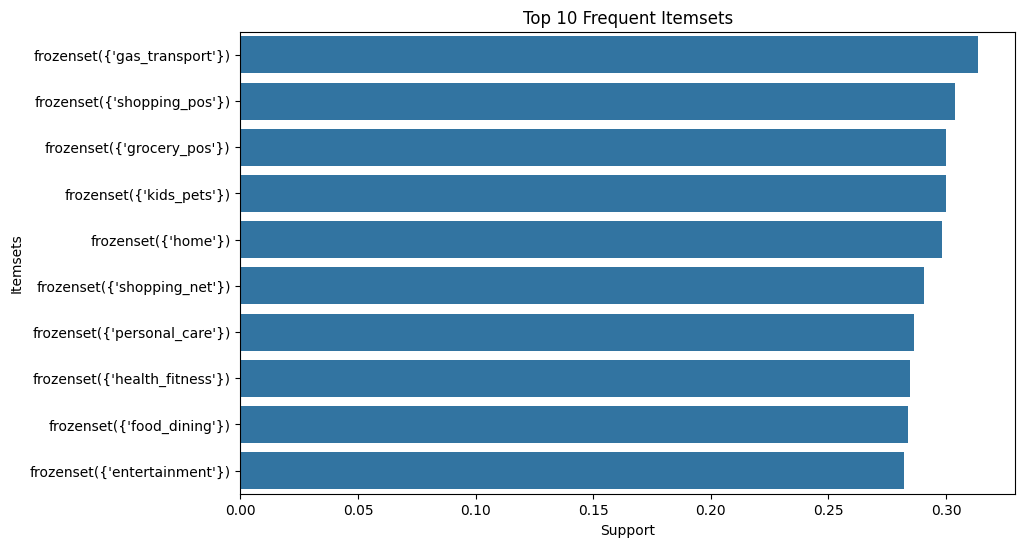

In [23]:
def plot_frequent_itemsets(frequent_itemsets):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='support', y='itemsets', data=frequent_itemsets.sort_values(by='support', ascending=False).head(10))
    plt.title('Top 10 Frequent Itemsets')
    plt.xlabel('Support')
    plt.ylabel('Itemsets')
    plt.show()

plot_frequent_itemsets(frequent_itemsets_big)
plot_frequent_itemsets(frequent_itemsets_small)


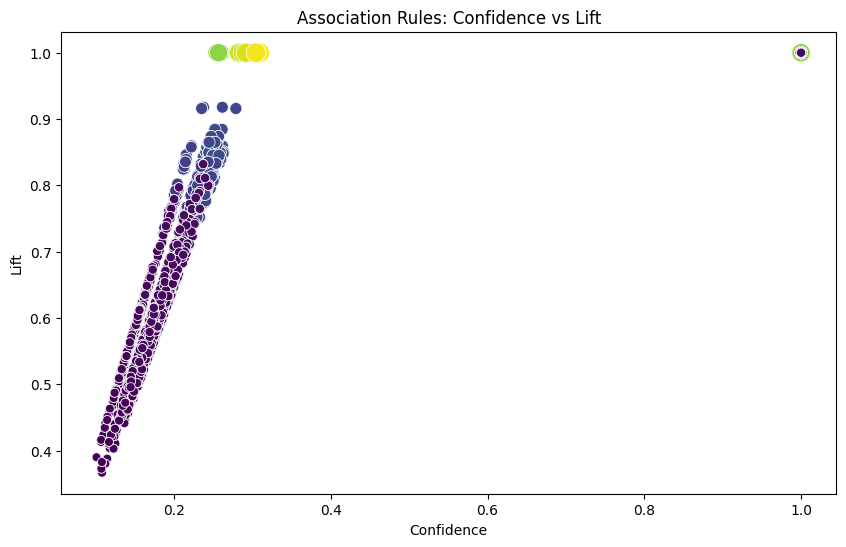

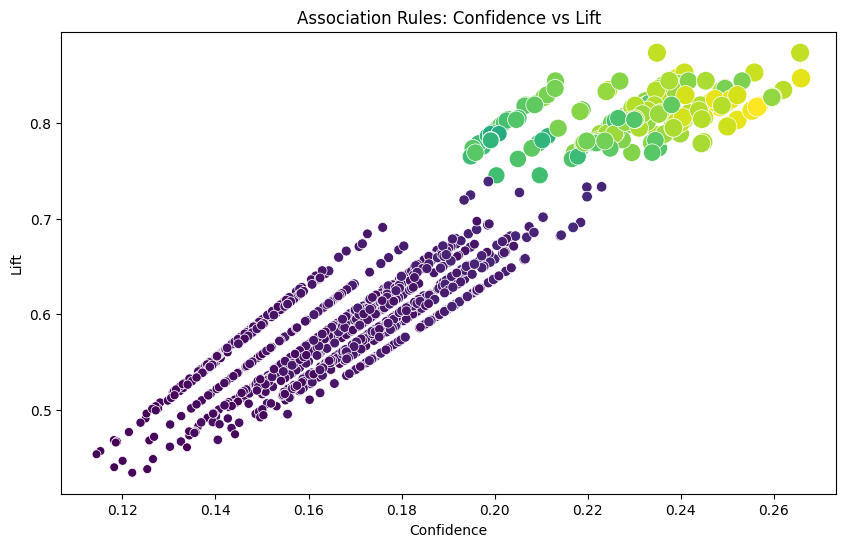

In [ ]:
def plot_association_rules(rules):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='confidence', y='lift', data=rules, hue='support', palette='viridis', size='support', sizes=(40, 200), legend=False)
    plt.title('Association Rules: Confidence vs Lift')
    plt.ylim(0, 1)
    plt.xlabel('Confidence')
    plt.ylabel('Lift')
    plt.show()

plot_association_rules(rules_big)
plot_association_rules(rules_small)

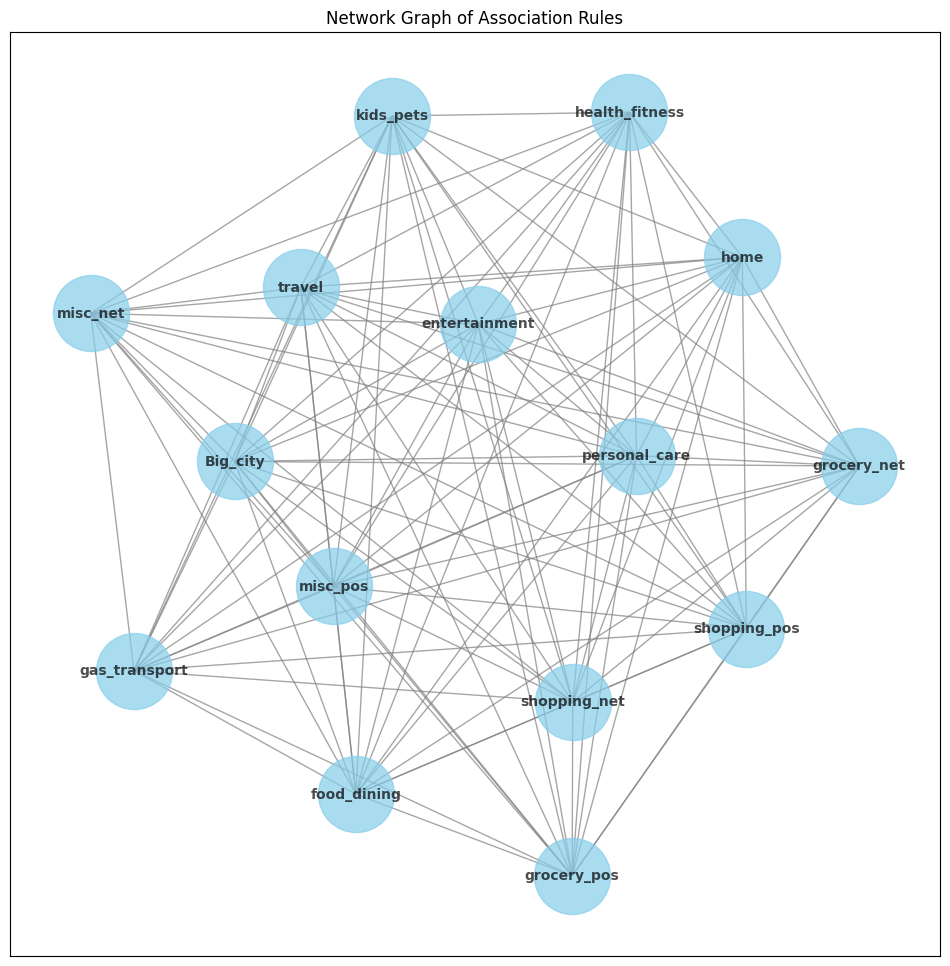

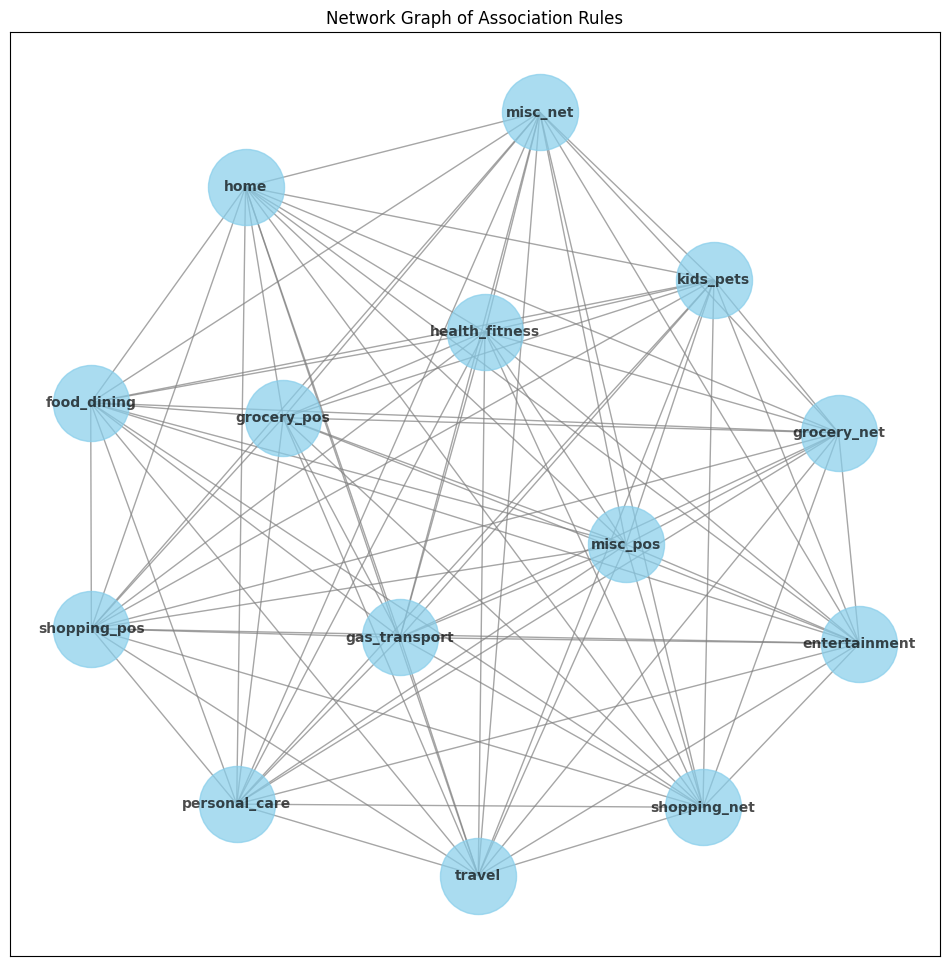

In [26]:
def plot_network_of_rules(rules):
    G = nx.Graph()
    for _, row in rules.iterrows():
        for antecedent in row['antecedents']:
            for consequent in row['consequents']:
                G.add_edge(str(antecedent), str(consequent), weight=row['lift'])

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=0.15, iterations=20)
    nx.draw_networkx(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray', width=1, alpha=0.7)
    plt.title('Network Graph of Association Rules')
    plt.show()

plot_network_of_rules(rules_big)
plot_network_of_rules(rules_small)

In [27]:
def display_top_rules(rules, top_n=10):
    top_rules = rules.sort_values(by='lift', ascending=False).head(top_n)
    print(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

display_top_rules(rules_big)
display_top_rules(rules_small)

                                antecedents       consequents   support  \
11                         (health_fitness)        (Big_city)  0.281566   
12                               (Big_city)            (home)  0.304641   
0                                (Big_city)   (entertainment)  0.284936   
1                           (entertainment)        (Big_city)  0.284936   
2                                (Big_city)     (food_dining)  0.294270   
3                             (food_dining)        (Big_city)  0.294270   
4272  (travel, personal_care, shopping_pos)        (Big_city)  0.011408   
4279   (travel, shopping_net, shopping_pos)        (Big_city)  0.013223   
10                               (Big_city)  (health_fitness)  0.281566   
27                                 (travel)        (Big_city)  0.256676   

      confidence  lift  
11      1.000000   1.0  
12      0.304641   1.0  
0       0.284936   1.0  
1       1.000000   1.0  
2       0.294270   1.0  
3       1.000000   1.0  

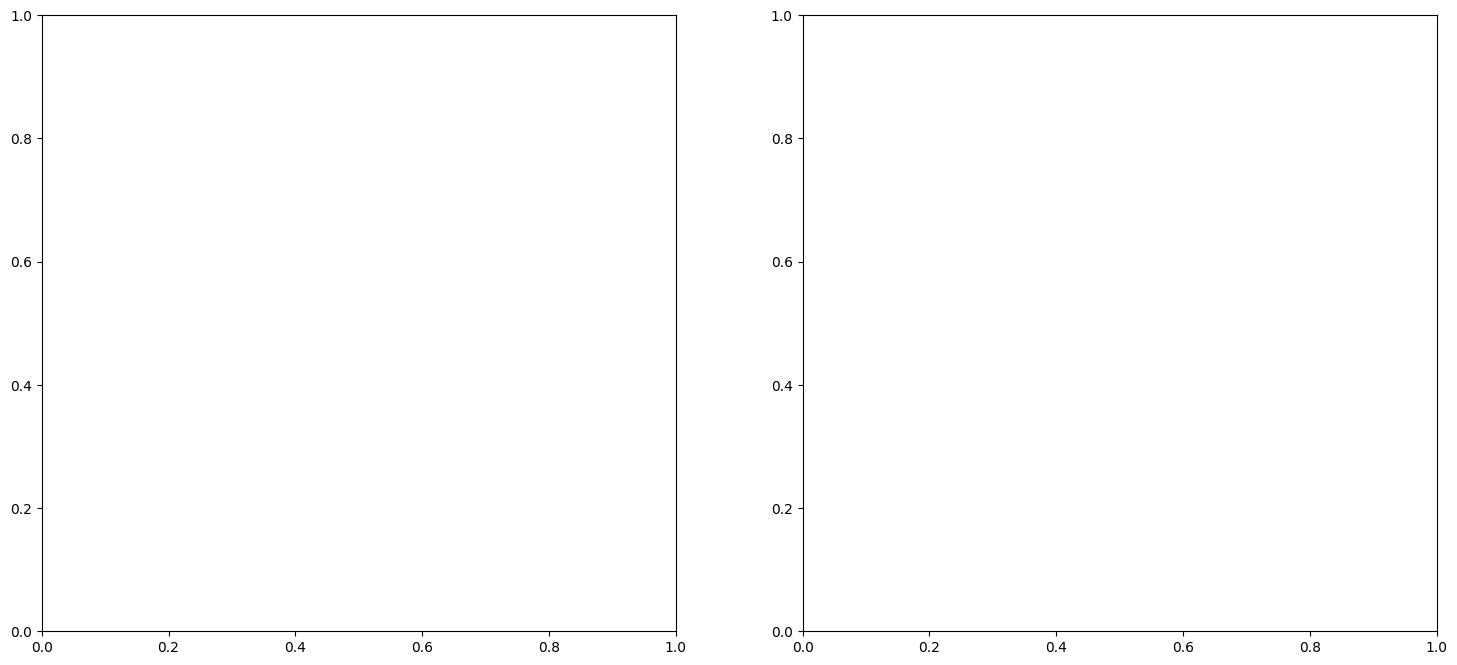

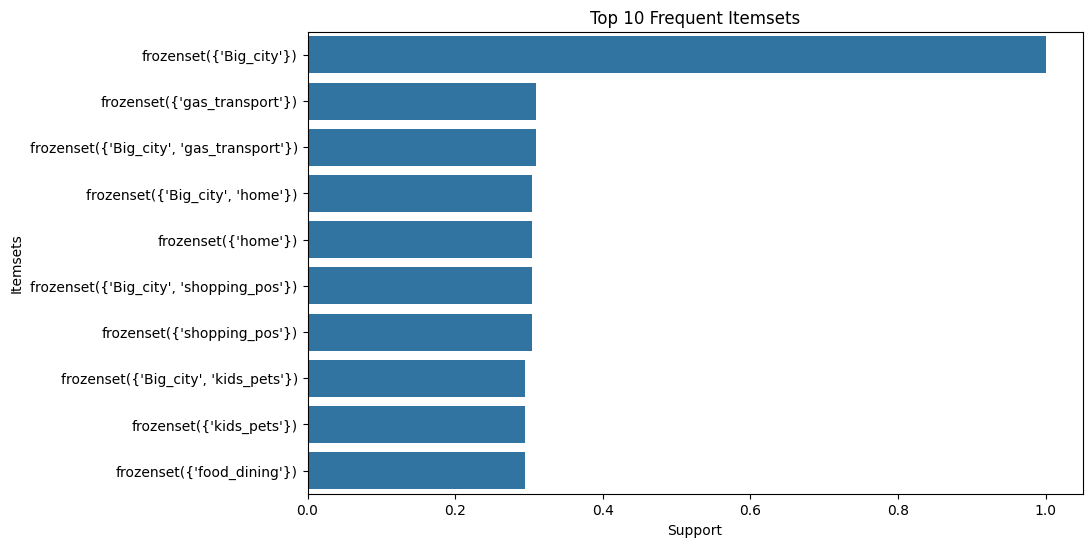

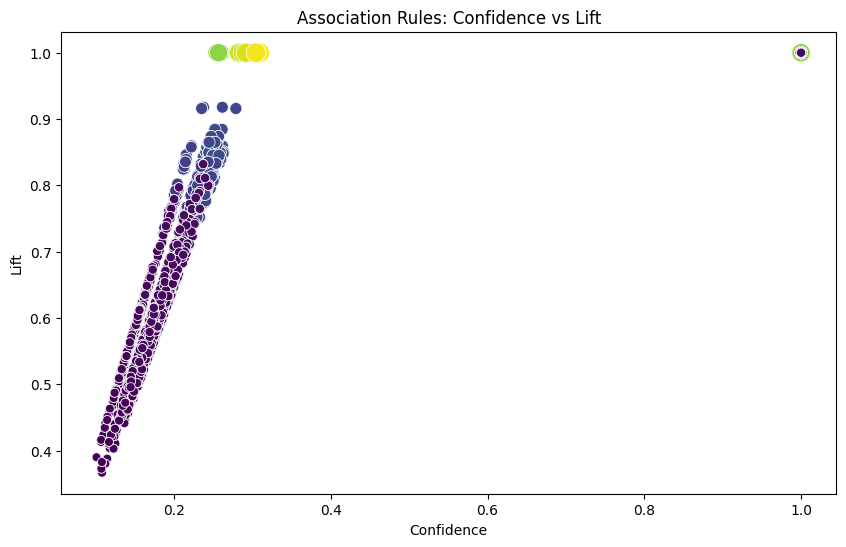

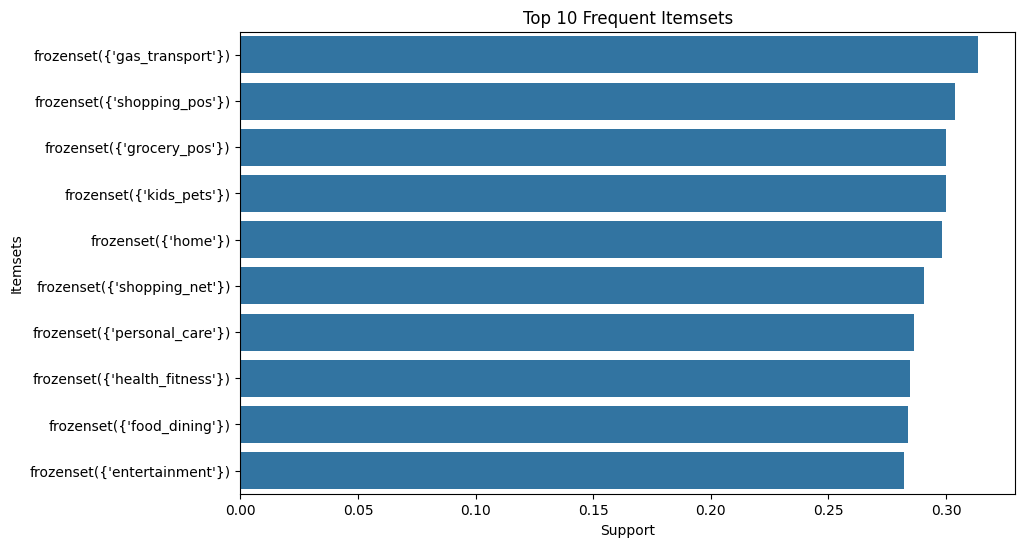

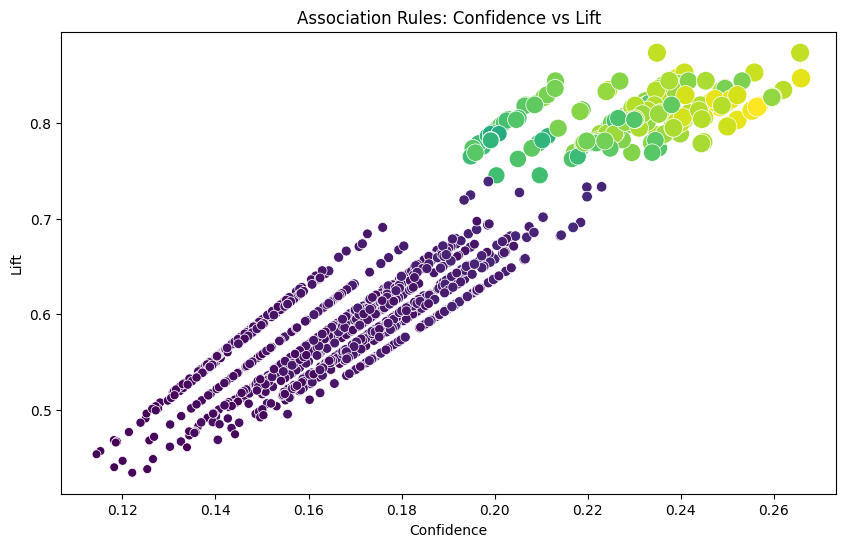

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

plot_frequent_itemsets(frequent_itemsets_big)
plot_association_rules(rules_big)

plot_frequent_itemsets(frequent_itemsets_small)
plot_association_rules(rules_small)

In [29]:
# Sort rules by lift and confidence for better insights
rules_big_sorted = rules_big.sort_values(by=['lift', 'confidence'], ascending=False)
rules_small_sorted = rules_small.sort_values(by=['lift', 'confidence'], ascending=False)

print("Top 5 Big City Rules (Sorted by Lift and Confidence):")
print(rules_big_sorted.head())

print("Top 5 Small City Rules (Sorted by Lift and Confidence):")
print(rules_small_sorted.head())


Top 5 Big City Rules (Sorted by Lift and Confidence):
       antecedents consequents  antecedent support  consequent support  \
1  (entertainment)  (Big_city)            0.284936                 1.0   
3    (food_dining)  (Big_city)            0.294270                 1.0   
5  (gas_transport)  (Big_city)            0.309308                 1.0   
7    (grocery_net)  (Big_city)            0.258750                 1.0   
9    (grocery_pos)  (Big_city)            0.293752                 1.0   

    support  confidence  lift  representativity  leverage  conviction  \
1  0.284936         1.0   1.0               1.0       0.0         inf   
3  0.294270         1.0   1.0               1.0       0.0         inf   
5  0.309308         1.0   1.0               1.0       0.0         inf   
7  0.258750         1.0   1.0               1.0       0.0         inf   
9  0.293752         1.0   1.0               1.0       0.0         inf   

   zhangs_metric   jaccard  certainty  kulczynski  
1         

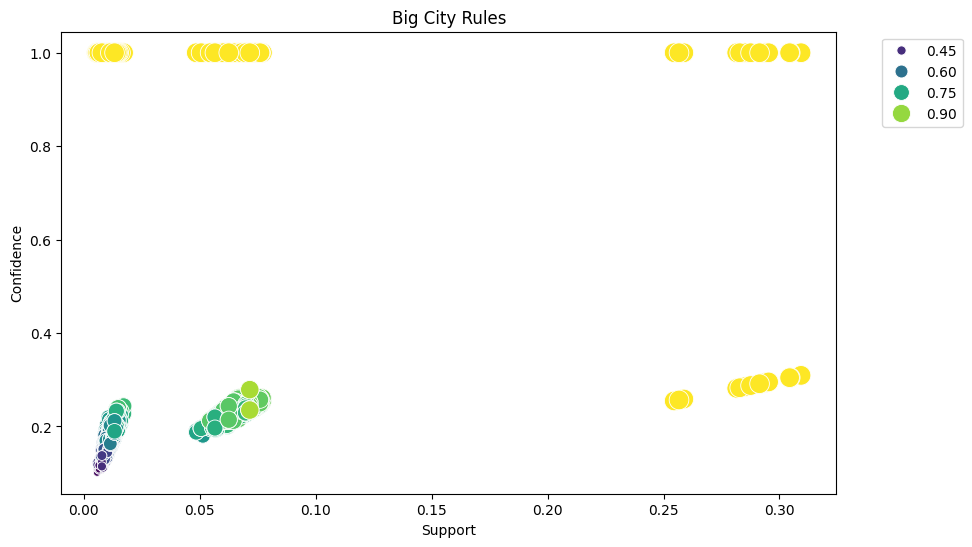

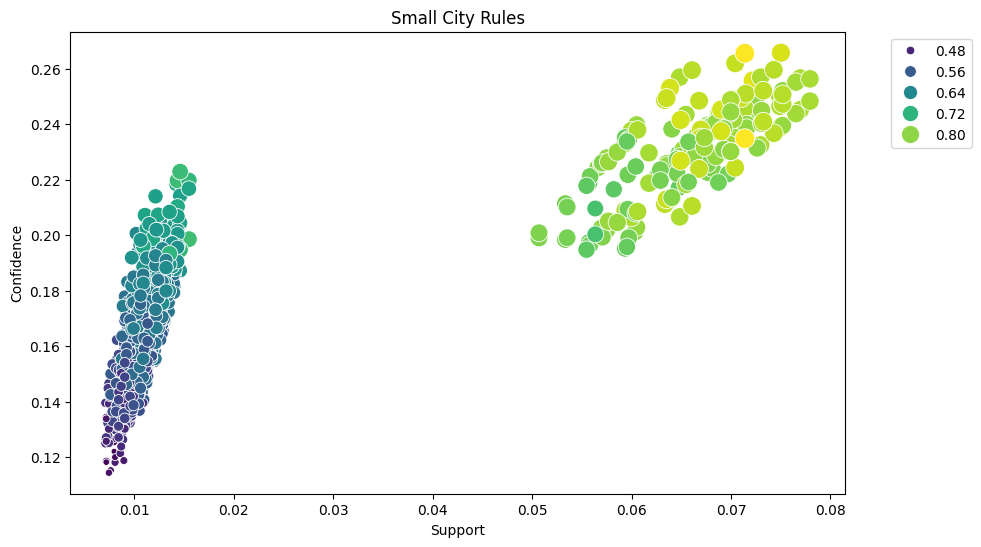

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_rules(rules, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=rules, x="support", y="confidence", size="lift", hue="lift", palette="viridis", sizes=(20, 200))
    plt.title(title)
    plt.xlabel("Support")
    plt.ylabel("Confidence")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Plot for big and small city rules
plot_rules(rules_big, "Big City Rules")
plot_rules(rules_small, "Small City Rules")


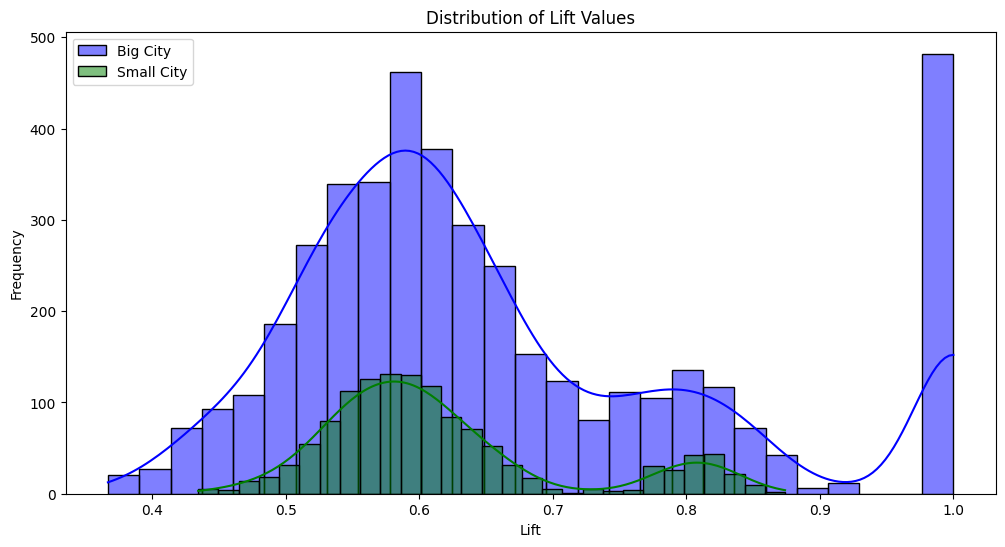

In [31]:
plt.figure(figsize=(12, 6))
sns.histplot(rules_big['lift'], kde=True, color='blue', label='Big City')
sns.histplot(rules_small['lift'], kde=True, color='green', label='Small City')
plt.title('Distribution of Lift Values')
plt.xlabel('Lift')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [11]:
# Rule statistics
print(f"Number of Rules (Big City): {len(rules_big)}")
print(f"Number of Rules (Small City): {len(rules_small)}")

# Average lift comparison
print(f"Average Lift (Big City): {rules_big['lift'].mean():.2f}")
print(f"Average Lift (Small City): {rules_small['lift'].mean():.2f}")


Number of Rules (Big City): 4290
Number of Rules (Small City): 1274
Average Lift (Big City): 0.66
Average Lift (Small City): 0.62


In [32]:
print("Top Frequent Itemsets (Big City):")
print(frequent_itemsets_big.sort_values(by='support', ascending=False).head())

print("Top Frequent Itemsets (Small City):")
print(frequent_itemsets_small.sort_values(by='support', ascending=False).head())


Top Frequent Itemsets (Big City):
     support                   itemsets
0   1.000000                 (Big_city)
3   0.309308            (gas_transport)
17  0.309308  (Big_city, gas_transport)
21  0.304641           (Big_city, home)
7   0.304641                     (home)
Top Frequent Itemsets (Small City):
     support         itemsets
2   0.313783  (gas_transport)
12  0.303963   (shopping_pos)
4   0.299805    (grocery_pos)
7   0.299805      (kids_pets)
6   0.298213           (home)
